# Titanic survivorship prediction
In this project I'll try to predict the survivors from the Titanic shipwreck using ML models.
## Data dictionary
| Variable | Meaning                                  | Key                                            |
|----------|------------------------------------------|------------------------------------------------|
| survival | Survival                                 | 0 = No, 1 = Yes                                |
| pclass   | Ticket Class                             | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                      | 0 = Male, 1 = Female                           |
| Age      | Age in years                             |                                                |
| sibsp    | # of siblings/spouses aboard the Titanic |                                                |
| parch    | # of parents/children aboard the Titanic |                                                |
| ticket   | Ticket number                            |                                                |
| fare     | Passenger fare                           |                                                |
| cabin    | Cabin number                             |                                                |
| embarked | Port of embarkation                      | C = Cherbourg, Q = Queenstown, S = Southampton |


In [49]:
#Data wrangling
import pandas as pd
import numpy as np
import random

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
#Jupyter notebook implementation
%matplotlib inline 

#Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = pd.concat([train_df, test_df])
#Lowercase columns
train_df.columns = map(str.lower, train_df.columns)
test_df.columns = map(str.lower, test_df.columns)
combine.columns = map(str.lower, combine.columns)

In [3]:
combine.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Analyzing categorical features

We'll analyze the features to determine which should we add to the final model, to do this we'll get the correlation between the features and survivorship.


*Correlation between Pclass and survivorship.*

In [4]:
train_df[['pclass', 'survived']].groupby(['pclass'], as_index = False).mean().sort_values(by = 'survived', ascending = False)

,pclass,survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


**Pclass** Significant correlation between pclass = 1 and survivorship. We should include this feature to the model

*Correlation between sex and survivorship*

In [5]:
#Correlation between sex and survivorship
train_df[['sex', 'survived']].groupby(['sex'], as_index = False).mean().sort_values(by = 'survived', ascending = False)

,sex,survived
0,female,0.742038
1,male,0.188908


**Sex** has a significant correlation with survivorship. We will include this feature in the model

*Correlation between siblings & parent and survivorship*

In [6]:
train_df[['sibsp', 'survived']].groupby(['sibsp'], as_index = False).mean().sort_values(by = 'survived', ascending = False)

,sibsp,survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


**Sibsp** has a zero correlation with survivorship for certain values. So we might not add it to the model just yet.

*Correlation between patch and survivorship*

In [7]:
train_df[['parch', 'survived']].groupby(['parch'], as_index = False).mean().sort_values(by = 'survived', ascending = False)

,parch,survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


**Parch** , just like sibsp, has certain values which has no correlation with survivorship. 

We should derive new features from these two.

## Analyzing numerical features

To analyze numerical features and our goal we can use histogram charts. This charts can show the distribution of samples using automatic or manually defined bands.

*Relationshiop between age and survivorship*

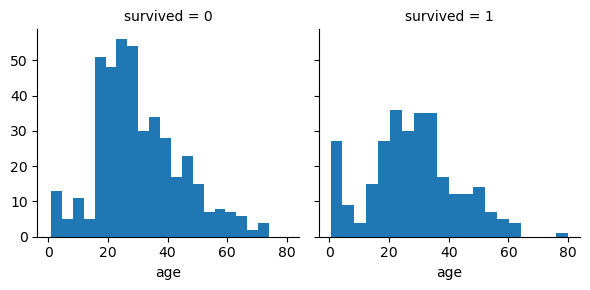

In [8]:
h = sns.FacetGrid(train_df, col = 'survived')
h.map(plt.hist, 'age', bins = 20)

As we can see, infants (age < 5) had a high survival rate (chart survived = 1). And a large number of 15-30 passengers did not survive.

Taking this into account, we should include age into our model (grouped by age)

We can combine multiple features using a single plot for better readability using categorical and numerical values.

*Relationship between age, survivorship and pclass*

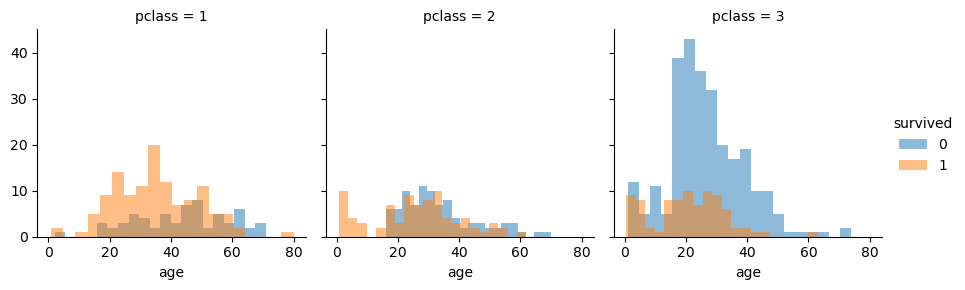

In [9]:
#Survived in same chart
grid = sns.FacetGrid(train_df, col = 'pclass', hue = 'survived')
#Different chart for survived value
#grid = sns.FacetGritd(train_df, col = 'survived', row = 'pclass', size = 2.2, aspect = 1.6)
grid.map(plt.hist, 'age', alpha = .5, bins = 20)
grid.add_legend()

This graph shows that first class passangers had better survival rates than the rest.

*Relationship between fare, embarked, and survivorship*

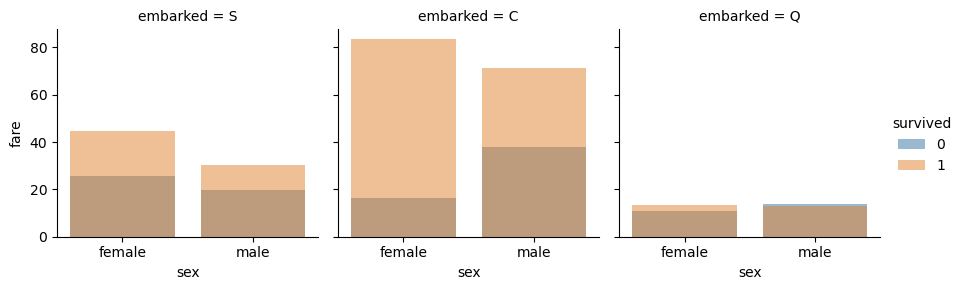

In [10]:
grid = sns.FacetGrid(train_df, col = 'embarked', hue = 'survived')
grid.map(sns.barplot, 'sex', 'fare', alpha = .5, errorbar = None, order = ['female', 'male'])
grid.add_legend()

Higher fare paying passengers had better survival, and port of embarcation correlates with survival rates.

## Cleaning data

### Deleting unused features
Taking into account that *ticket* feature contains a high number of duplicates (22%) and might not have a correlation with survival, we should drop it.

Cabin feature is highly incomplete so should also be dropped.

PassengerId can be dropped from training dataset because it doesn't contribute to survival.

Name feature has no correlation with survival so it also might be dropped.

In [11]:
train_df = train_df.drop(['ticket', 'cabin'], axis = 1)
test_df = test_df.drop(['ticket', 'cabin'], axis = 1)
combine = [train_df, test_df]

Before dropping *name* and *passengerid* we will identify if they can be useful to our analysis.

We'll use name to substract any title the person might have and see how it correlates with survivorship

In [12]:
for dataset in combine:
    dataset['title'] = dataset.name.str.extract('([A-Za-z]+)\.', expand = False)

pd.crosstab(train_df['title'], train_df['sex'])

sex,female,male
title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We can replace non-popular titles with a rare tag.

In [13]:
for dataset in combine:
    dataset['title'] = dataset['title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['title'] = dataset['title'].replace('Ms', 'Miss')
    dataset['title'] = dataset['title'].replace('Mlle', 'Miss')
    dataset['title'] = dataset['title'].replace('Mme', 'Mrs')
    
train_df[['title', 'survived']].groupby(['title'], as_index = False).mean()

,title,survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Turning these categorical titles to ordianl:

In [14]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['title'] = dataset['title'].map(title_mapping)
    dataset['title'] = dataset['title'].fillna(0)
train_df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


And now we can drop the name and passengerid features

In [15]:
train_df = train_df.drop(['name', 'passengerid'], axis = 1)
test_df = test_df.drop(['name', 'passengerid'], axis = 1)
combine = [train_df, test_df]

### Converting categorical features to ordinal

We can convert the rest of the categorical features to ordinal to be able to utilize them in the model.

*Changing sex feature*

In [16]:
for dataset in combine:
    dataset['sex'] = dataset['sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


*Changing embarked feature*

Embarked has missing two values so we will simply fill those with the most common occurance.

In [17]:
#Getting the most common embarked value
freq_port = train_df.embarked.dropna().mode()[0]
freq_port

'S'

In [18]:
#Adding most common value to NA
for dataset in combine:
    dataset['embarked'] = dataset['embarked'].fillna(freq_port)
    
train_df[['embarked', 'survived']].groupby(['embarked'], as_index = False).mean().sort_values(by = 'survived', ascending = False)

,embarked,survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


**Converting to numeric**

In [19]:
for dataset in combine:
    dataset['embarked'] = dataset['embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
train_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
0,0,3,0,22.0,1,0,7.2500,0,1
1,1,1,1,38.0,1,0,71.2833,1,3
2,1,3,1,26.0,0,0,7.9250,0,2
3,1,1,1,35.0,1,0,53.1000,0,3
4,0,3,0,35.0,0,0,8.0500,0,1


### Filling continuous feature

There are three ways to complete a numerical continuous feature:
1. Generate random numbers between mean and standard deviation
2. Use correlated features. In this case, guess age values using median values for age across sets of Pclass and Gender combinations.
3. Combine methods 1 & 2 so instead of using the median, use random numbers between mean and standard deviation based on combinations of Pclass and Gender.

To avoid randomness we'll stick to method #2

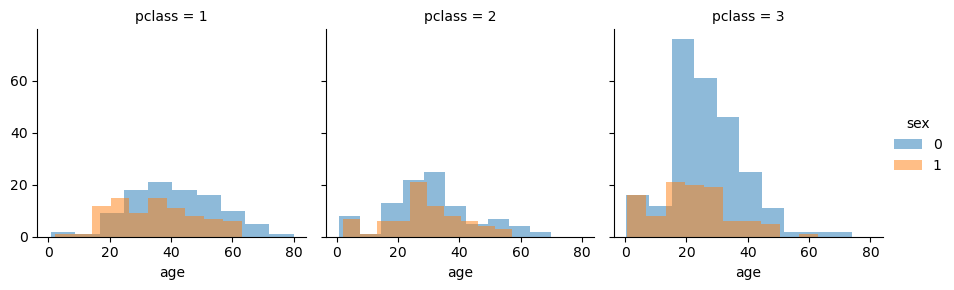

In [20]:
grid = sns.FacetGrid(train_df, col = 'pclass', hue = 'sex')
grid.map(plt.hist, 'age', alpha = .5)
grid.add_legend()

In [21]:
#Creating empty array to contain guessed age values
guess_ages = np.zeros((2, 3))

Now iterate over sex and Pclass to calculate guessed values of age for the combinations

In [22]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['sex'] == i) & (dataset['pclass'] == j+1)]['age'].dropna()

            # Method 3:
            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.age.isnull()) & (dataset.sex == i) & (dataset.pclass == j+1),\
                    'age'] = guess_ages[i,j]

    dataset['age'] = dataset['age'].astype(int)

train_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
0,0,3,0,22,1,0,7.2500,0,1
1,1,1,1,38,1,0,71.2833,1,3
2,1,3,1,26,0,0,7.9250,0,2
3,1,1,1,35,1,0,53.1000,0,3
4,0,3,0,35,0,0,8.0500,0,1


Creation of age bands and its correlation with survivorship

In [23]:
train_df['ageband'] = pd.cut(train_df['age'], 5)

train_df[['ageband', 'survived']].groupby(['ageband'], as_index = False).mean().sort_values(by = 'ageband', ascending = True)

,ageband,survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


Replacing age with ordinals based on bands (turning it categorical)

In [24]:
for dataset in combine:
    dataset.loc[dataset['age'] <= 16, 'age'] = 0
    dataset.loc[(dataset['age'] > 16) & (dataset['age'] <= 32), 'age'] = 1
    dataset.loc[(dataset['age'] > 32) & (dataset['age'] <= 48), 'age'] = 2
    dataset.loc[(dataset['age'] > 48) & (dataset['age'] <= 64), 'age'] = 3
    dataset.loc[(dataset['age'] > 64), 'age'] = 4

train_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title,ageband
0,0,3,0,1,1,0,7.2500,0,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,1,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,0,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,0,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,0,1,"(32.0, 48.0]"


We can now remove the AgeBand feature

In [25]:
train_df = train_df.drop(['ageband'], axis = 1)
combine = [train_df, test_df]

train_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
0,0,3,0,1,1,0,7.2500,0,1
1,1,1,1,2,1,0,71.2833,1,3
2,1,3,1,1,0,0,7.9250,0,2
3,1,1,1,2,1,0,53.1000,0,3
4,0,3,0,2,0,0,8.0500,0,1


## Creating new features

We should create new features when this can potentially simplify and give more meaning to our model.

*Creating FamilySize to drop parch and sibsp from our dataset*

In [26]:
for dataset in combine:
    dataset['familySize'] = dataset['sibsp'] + dataset['parch'] + 1
    
train_df[['familySize', 'survived']].groupby(['familySize'], as_index = False).mean().sort_values(by = 'survived', ascending = False)

,familySize,survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


*Creating a categorical feature isAlone (0 = with family, 1 = alone)*

In [27]:
for dataset in combine:
    dataset['isAlone'] = 0
    dataset.loc[dataset['familySize'] == 1, 'isAlone'] = 1

train_df[['isAlone', 'survived']].groupby(['isAlone'], as_index = False).mean()

,isAlone,survived
0,0,0.505650
1,1,0.303538


Drop parch, sibsp and familySize to use isAlone

In [28]:
train_df = train_df.drop(['parch', 'sibsp', 'familySize'], axis = 1)
test_df = test_df.drop(['parch', 'sibsp', 'familySize'], axis = 1)
combine = [train_df, test_df]

train_df.head()

,survived,pclass,sex,age,fare,embarked,title,isAlone
0,0,3,0,1,7.2500,0,1,0
1,1,1,1,2,71.2833,1,3,0
2,1,3,1,1,7.9250,0,2,1
3,1,1,1,2,53.1000,0,3,0
4,0,3,0,2,8.0500,0,1,1


Creating an artificial feature combining pclass and age

In [29]:
for dataset in combine:
    dataset['age*class'] = dataset.age * dataset.pclass

train_df.loc[:, ['age*class', 'age', 'pclass']].head(10)

,age*class,age,pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Completing and converting numeric feature

We'll fill the missing values in the test dataset using mode to get the value that occurs most frequently.

In [30]:
test_df['fare'].fillna(test_df['fare'].dropna().median(), inplace = True)
test_df.head()

,pclass,sex,age,fare,embarked,title,isAlone,age*class
0,3,0,2,7.8292,2,1,1,6
1,3,1,2,7.0000,0,3,0,6
2,2,0,3,9.6875,2,1,1,6
3,3,0,1,8.6625,0,1,1,3
4,3,1,1,12.2875,0,3,0,3


*Creating fareBand*

In [31]:
train_df['fareBand'] = pd.qcut(train_df['fare'], 4)
train_df[['fareBand', 'survived']].groupby(['fareBand'], as_index = False).mean().sort_values(by = 'fareBand', ascending = True)

,fareBand,survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Convert fare to ordinal values based on fareBand

In [32]:
for dataset in combine:
    dataset.loc[dataset['fare'] <= 7.91, 'fare'] = 0
    dataset.loc[(dataset['fare'] > 7.91) & (dataset['fare'] <= 14.454), 'fare'] = 1
    dataset.loc[(dataset['fare'] > 14.454) & (dataset['fare'] <= 31), 'fare'] = 2
    dataset.loc[(dataset['fare'] > 31), 'fare'] = 3
    
    dataset['fare'] = dataset['fare'].astype(int)

train_df = train_df.drop(['fareBand'], axis = 1)
combine = [train_df, test_df]

train_df.head(10)

,survived,pclass,sex,age,fare,embarked,title,isAlone,age*class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [33]:
test_df.head(10)

,pclass,sex,age,fare,embarked,title,isAlone,age*class
0,3,0,2,0,2,1,1,6
1,3,1,2,0,0,3,0,6
2,2,0,3,1,2,1,1,6
3,3,0,1,1,0,1,1,3
4,3,1,1,1,0,3,0,3
5,3,0,0,1,0,1,1,0
6,3,1,1,0,2,2,1,3
7,2,0,1,2,0,1,0,2
8,3,1,1,0,1,3,1,3
9,3,0,1,2,0,1,0,3


# Modeling & predicting

Taking into account that we want to identify a relationship between output (survivorship) with features, and we are performing a *supervised learning* technique, we can narrow our choice of models to a few:
- Logistic Regression
- K-Nearest Neighbors (KNN)
- Support Vector Machines (SVM)
- Naive Bayes classifier
- Decision tree
- Random forrest
- Perceptron
- Artificial neural network
- Relevance Vector Machine (RVM)

In [37]:
x_train = train_df.drop('survived', axis = 1)
y_train = train_df['survived']
x_test = test_df.copy()

x_train.shape, y_train.shape, x_test.shape

((891, 8), (891,), (418, 8))

***Logistic Regression***

Logistic regression measures the relationship between the categorical dependent variable and its independent variables by estimating probabilities using a logistic function.

In [38]:
#Logistic Regression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
acc_log = round(logreg.score(x_train, y_train) * 100, 2)
acc_log

81.37

The Logistic Regression model has an accuracy of 81.37%.

We can calculate the coefficient of the features to validate our assumptions and decisions.

Positive coefficients increase the log-odds of the response, and negative coefficients decrease it.

In [39]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['feature']
coeff_df['coefficient'] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by = 'coefficient', ascending = False)

,feature,coefficient
1,sex,2.201057
5,title,0.406027
4,embarked,0.276628
6,isAlone,0.185986
7,age*class,-0.050260
3,fare,-0.071665
2,age,-0.469638
0,pclass,-1.200309


- Sex is the highest positive coefficient, implying that being a woman (male: 0, female: 1) increases your probabilities to survive the most.
- as pclass increases, your probabilities of survival decreases the most
- Title has the second highest positive correlation
- Age has the second highest negative correlation (as age increases, your probabilities of surviving decreases)

***Support Vector Machines***

SVM are supervised learning models wiwth associated learning algorithms that analyze data used for classification and regression analysis.

In [42]:
#Support Vector Machines

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
acc_svc = round(svc.score(x_train, y_train) * 100, 2)
acc_svc

82.83

This model has a higher accuracy than the Logistic Regression model.

In [46]:
#See coefficients?

***K-Nearest Neighbors***
<br>
The k-nearest neighbors algorithm is a non-parametric methos used for classification and regression. A sample is classified by a majority vote of its neighbors.

In [47]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
acc_knn = round(knn.score(x_train, y_train) * 100, 2)
acc_knn

82.83

This model has the same accuracy than the SVM model.

***Gaussian Naive Bayes***


In [50]:
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_test)
acc_gaussian = round(gaussian.score(x_train, y_train) * 100, 2)
acc_gaussian

76.88

GNB has the lowerst accuracy so far
<br>
<br>
<br>
***Perceptron***

In [51]:
perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_test)
acc_perceptron = round(perceptron.score(x_train, y_train) * 100, 2)
acc_perceptron

79.35

***Linear SVC***

In [52]:
linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_test)
acc_linear_svc = round(linear_svc.score(x_train, y_train) * 100, 2)
acc_linear_svc

C:\Users\Diego\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


79.46

***Stochastic Gradient Descent***


In [53]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)
acc_sgd = round(sgd.score(x_train, y_train) * 100, 2)
acc_sgd

77.89

***Decision Tree***

In [54]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
y_pred = decision_tree.predict(x_test)
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree 

86.64

***Random Forest***

In [55]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
random_forest.score(x_train, y_train)
acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)
acc_random_forest

86.64

### Model evaluation

In [56]:
models = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'Logistic Regression', 'Random Forest', 'NB', 'Perceptron', 'SGD', 'Linear SVC', 'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron, acc_sgd, acc_linear_svc, acc_decision_tree]
})
models.sort_values(by = 'Score', ascending = False)

,Model,Score
3,Random Forest,86.64
8,Decision Tree,86.64
0,SVM,82.83
1,KNN,82.83
2,Logistic Regression,81.37
7,Linear SVC,79.46
5,Perceptron,79.35
6,SGD,77.89
4,NB,76.88
